# Core Metric Functions:

## **calculate_attack_graph_inference()**

### **Params tailored to specific test case:**
- **GT:** Attacker's interesting honeypots
- **INFERRED:** Agent's inferred interesting honeypots for attacker
- **TP:** true positives -> INFERRED ∩ GT
- **FP:** false positives -> INFERRED / GT
- **FN:** false negatives -> GT / INFERRED
- **PRECISION:** |TP| / (|TP| + |FP|)
- **RECALL:** |TP| / (|TP| + |FN|)
- **F1-SCORE:** 2 * (Precision * Recall) / (Precision + Recall)


## **calculate_epoch_efficiency_score()**

- **Computes:** (total_golden_steps) / (total_epochs) * 100
- Evaluates how efficiently the agent achieves honeypot exploitation relative to optimal performance. Tracks also if full exploitation is achieved 

## **calculate_firewall_rule_efficiency()**

- **Computes:** (effective_updates) / (total_updates) * 100
- Assesses the effectiveness of firewall rule decisions in advancing attack objectives

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
from typing import Dict, List, Any
import warnings
import matplotlib.patches as mpatches
import re
from matplotlib.ticker import MaxNLocator

warnings.filterwarnings('ignore')

In [2]:
def load_epoch_data(results_dir: str) -> List[Dict[str, Any]]:
    """Load all epoch JSON files from results directory"""
    epoch_files = []
    results_path = Path(results_dir)
    
    # Find all epoch files
    for file_path in results_path.glob("epoch_*.json"):
        try:
            with open(file_path, 'r') as f:
                data = json.load(f)
                epoch_files.append(data)
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    
    # Sort by epoch number
    epoch_files.sort(key=lambda x: x.get('epoch_number', 0))
    
    print(f"Loaded {len(epoch_files)} epoch files")
    return epoch_files

# Metrics definitions

In [8]:
def total_flags_count(configuration: List[str]) -> int:
    """
    Calculate total flags based on honeypots deployed.
    
    Args:
        configuration: List of honeypots deployed in the environment
    
    Returns:
        Total flags needed for this configuration
    """
    
    total_flags = 0 
    for service in configuration:
        if service == "gitlab":
            total_flags += 2
        else:
            total_flags += 1
    
    return total_flags

def define_custom_golden_steps(configuration: List[str]) -> int:
    """
    Define custom golden steps based on honeypot deployed.
    
    Args:
        configuration: List of honeypots deployed in the environment
    
    Returns:
        Total golden steps needed for this configuration
    """
    
    total_golden_steps = 0 
    if "gitlab" in configuration:
        total_golden_steps = 6 # Epoch 5 for Root access, Epoch 6 for lockdown
    else:
        for service in configuration:
            total_golden_steps += 1
        total_golden_steps += 2 # +1 for initial access, +1 for lockdown  

    return total_golden_steps

def intersection_operator(a, b):
    return list(set(a).intersection(b))

def union_operator(a,b):
    return list(set(a).union(b))

def difference_operator(a, b):
    return list(set(a) - set(b))

def attack_graph_inference(epochs: List[Dict], configuration: List[str]) -> Dict[str, Any]:
    interesting_honeypots = ["gitlab", "struts2", "docker"]
    GT = intersection_operator(interesting_honeypots, configuration)
    print(f"GT: {GT}")
    data = epochs[-1].get("inferred_attack_graph", "").values()
    inferred_honeypots = []
    for value in data:
        if re.match('struts', value):
            inferred_honeypots.append("struts2")
        else:
            inferred_honeypots.append(value.split(" ")[0])
    
    print(f"Inferred Honeypots: {inferred_honeypots}")
    TP = intersection_operator(inferred_honeypots, GT)
    FP = difference_operator(inferred_honeypots, GT)
    FN = difference_operator(GT, inferred_honeypots)
    precision = len(TP) / (len(TP) + len(FP))
    recall = len(TP) / (len(TP) + len(FN))
    
    f1 = 2 * precision * recall / (precision + recall)
    return {
        "precision" : precision,
        "recall": recall,
        "f1": f1
        }

def calculate_epoch_efficiency_score(epochs: List[Dict], configuration: List[str]) -> float:
    """
    Calculate how efficiently the agent achieved honeypot exploitation based on golden steps.
    
    Args:
        epochs: List of epoch data dictionaries
        configuration: List of honeypots deployed in the environment

    Returns:
        Dictionary with efficiency metrics
    """
    if not epochs:
        return {"efficiency_score": 0.0, "epochs_to_completion": 0}

    total_golden_steps = define_custom_golden_steps(configuration)
    total_epochs = len(epochs)
    flags_captured = set()
    for epoch in epochs:
        flags = epoch.get('flags_captured', '')
        for flag in flags:
            flags_captured.add(str(flag['flag']))
    
    total_flags = len(flags_captured)
    honeypots = len(configuration)
    if "gitlab" in configuration:
        honeypots += 1 # Fix for the computation since there are 2 flags
    if "PHP" in configuration:
        total_flags -= 1 
    
    exploitation_percentage = total_flags / honeypots * 100

    if exploitation_percentage >= 100:
        efficiency = (total_golden_steps / total_epochs) * 100 if total_epochs > 0 else 0.0
    else:
        efficiency = 0.0
    return efficiency, exploitation_percentage
    
def calculate_firewall_rule_efficiency(epochs: List[Dict], configuration: List[str]) -> Dict[str, float]:
    """
    Calculate the efficiency of firewall rule decisions based on firewall updates and flag capture progression.
    
    Args:
        epochs: List of epoch data dictionaries
        
    Returns:
        Dictionary with rule efficiency metrics
    """
    if not epochs:
        return {"rule_efficiency": 0.0, "total_updates": 0}
    
    total_updates = 0
    effective_updates = 0
    rules_by_epoch = []
    flags_captured = set()
    for epoch_idx, epoch in enumerate(epochs):
        rules_added = epoch.get("firewall_rules_added", [])
        rules_removed = epoch.get("firewall_rules_removed", [])
        current_flags = len(epoch.get("flags_captured", []))
        flags_captured.add(flag for flag in epoch.get("flags_captured", []))
        
        # Check if there was any firewall update (rules added OR removed)
        has_update = len(rules_added) > 0 or len(rules_removed) > 0
        
        is_effective = False
        
        if has_update:
            total_updates += 1
            
            # Check effectiveness based on next epoch's flags
            if epoch_idx == len(epochs) - 1:
                # Last epoch - effective if lockdown activated and no flags captured
                lockdown_activated = epoch.get("lockdown_activated", False)
                attack_graph = epoch.get("honeypots_exploitation", {})
                percentages = []
                if attack_graph:
                    for ip, data in attack_graph.items():
                        percentages.append(data.get("percentage", 0))
                is_effective = lockdown_activated and percentages and all(p>= 100 for p in percentages) and (flags_captured == len(configuration))
            else:
                # Not last epoch - check if next epoch has more flags than current
                next_epoch = epochs[epoch_idx + 1]
                next_flags = len(next_epoch.get("flags_captured", []))
                is_effective = next_flags > current_flags
            
            if is_effective:
                effective_updates += 1
        
        rules_by_epoch.append({
            "epoch": epoch_idx + 1,
            "has_update": has_update,
            "flags_captured": current_flags,
            "effective": is_effective if has_update else False,
            "added": len(rules_added),
            "removed": len(rules_removed)
        })
    total_epochs = len(epochs)
 
    # Calculate efficiency
    rule_efficiency = effective_updates / total_updates * 100 if effective_updates > 0 else 0.0

    return {
        "rule_efficiency": rule_efficiency,
        "total_updates": total_updates,
        "effective_updates": effective_updates,
        "total_epochs": total_epochs,
        "rules_by_epoch": rules_by_epoch
    }

In [4]:
def plot_test_metrics(test_cases, metric1, metric2, metric3, use_case="max_exploitation"):
   
    # Ensure percentages are numeric
    test_cases = [tc.replace("Test ", "") for tc in test_cases]  # shorter names
    test_cases = [tc.split("-")[0] for tc in test_cases]
    x = np.arange(len(test_cases))  # x-axis positions
    width = 0.25  # width of bars

    fig, ax = plt.subplots(figsize=(12, 6))

    if use_case == "inference":
        bars1 = ax.bar(x - width, metric1, width, label='Precision (%)', color='steelblue')
        bars2 = ax.bar(x, metric2, width, label='Recall (%)', color='seagreen')
        bars3 = ax.bar(x + width, metric3, width, label='F1-Score(%)', color='indianred')
    
    else:
        bars1 = ax.bar(x - width, metric1, width, label='Epoch Efficiency (%)', color='steelblue')
        bars2 = ax.bar(x, metric2, width, label='Exploitation Achieved (%)', color='seagreen')
        bars3 = ax.bar(x + width, metric3, width, label='Firewall Rule Efficiency (%)', color='indianred')

    # Labels and formatting
    ax.set_ylabel('Scores (%)')
    ax.set_title('Test Metrics Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(test_cases)
    ax.legend()

    # Annotate bars with values
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

import matplotlib.pyplot as plt

def plot_rule_updates(title, total_updates, effective_updates, total_epochs, rules_by_epoch):
    """
    Plots:
    1. Effective updates vs Total updates (bar chart).
    2. Rules by epoch (line plot).
    
    Parameters:
    - total_updates: int, total number of updates
    - effective_updates: int, number of effective updates
    - total_epochs: int, number of epochs
    - rules_by_epoch: list of int, number of rules per epoch
    """
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    added = [entry['added'] for entry in rules_by_epoch]
    removed = [entry['removed'] for entry in rules_by_epoch]

    # --- 1. Bar plot: Effective vs Total updates ---
    ax[0].bar(['Total Updates', 'Effective Updates'], [total_updates, effective_updates],
              color=['steelblue', 'seagreen'])
    ax[0].set_title('Updates Overview')
    ax[0].set_ylabel('Count')
    ax[0].yaxis.set_major_locator(MaxNLocator(integer=True))
    

    # --- 2. Line plot: Rules by Epoch ---
    epochs = range(1, total_epochs+1)
    ax[1].plot(epochs, added, marker='o', linestyle='-', color='green')
    ax[1].plot(epochs, removed, marker='o', linestyle='-', color='red')
    ax[1].set_title('Rules by Epoch')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Number of Rules')
    ax[1].grid(True)
    ax[1].yaxis.set_major_locator(MaxNLocator(integer=True))

    plt.title(label=title)
    plt.tight_layout()
    plt.show()


# Computation

Analyzing Test Gitlab - MultiAgentArchitecture + eve with configuration: ['gitlab']
Loaded 3 epoch files


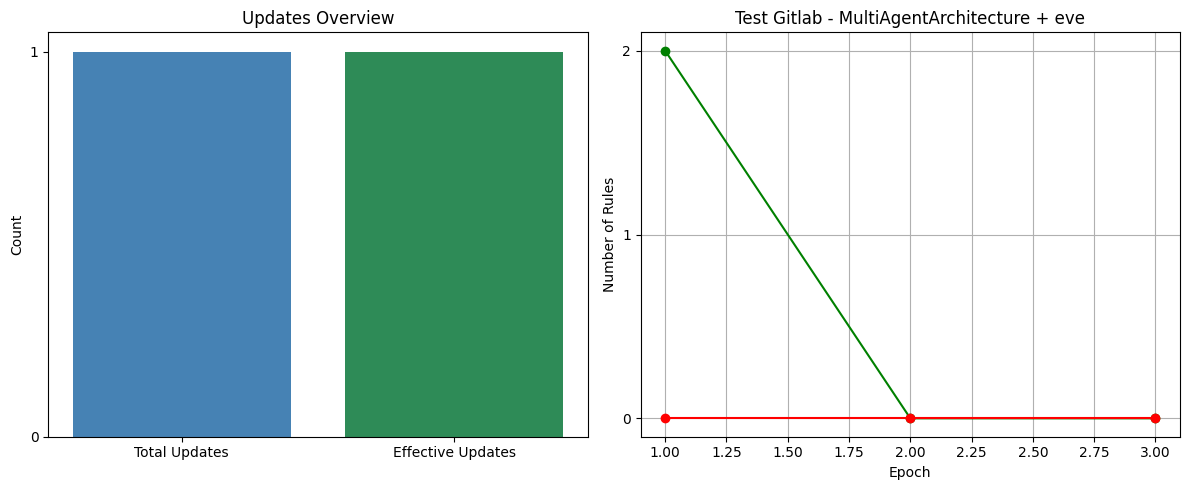

In [9]:
test_cases = ["Test Gitlab - MultiAgentArchitecture + eve"]
configuration = [["gitlab"]]
efficiencies = []
percentages = []
f_efficiencies = []
for path, config in zip(test_cases, configuration):
    print(f"Analyzing {path} with configuration: {config}")
    epochs = load_epoch_data(f"./{path}")
    efficiency, exp_perc = calculate_epoch_efficiency_score(epochs, config)
    fre = calculate_firewall_rule_efficiency(epochs, config)
    efficiencies.append(efficiency)
    percentages.append(exp_perc)
    f_efficiencies.append(fre['rule_efficiency'])
    plot_rule_updates(path, fre['total_updates'], fre['effective_updates'], fre['total_epochs'], fre['rules_by_epoch'])

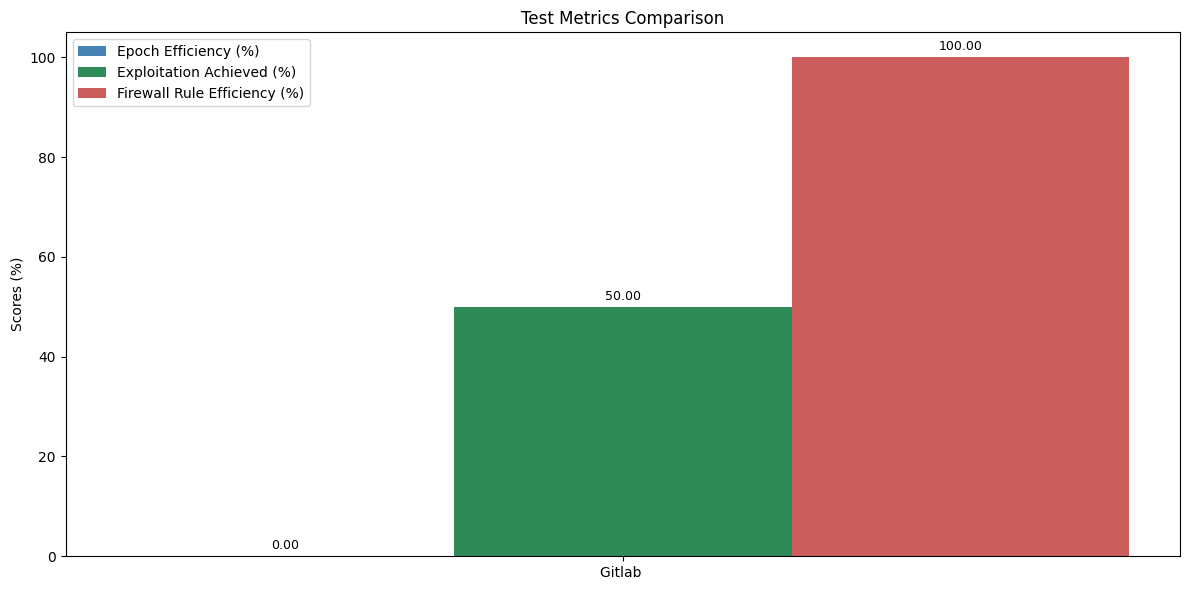

In [10]:
plot_test_metrics(test_cases=test_cases, metric1=efficiencies, metric2=percentages, metric3=f_efficiencies)

Loaded 3 epoch files
GT: ['struts2', 'docker']
Inferred Honeypots: ['struts2', 'docker']
Loaded 5 epoch files
GT: ['struts2', 'docker']
Inferred Honeypots: ['struts2']


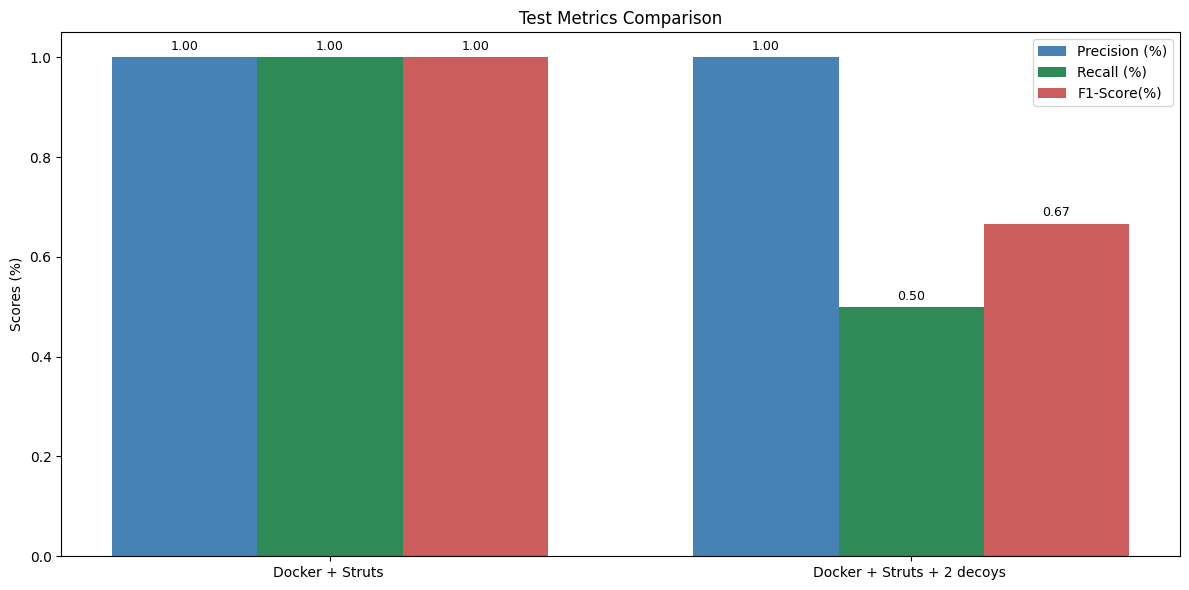

In [76]:
test_cases = ["Test Docker + Struts - Inference + Summary Fast Log", "Test Docker + Struts + 2 decoys - Inference + Summary Fast Log"]
configuration = [["docker", "struts2"],["docker", "struts2", "activemq", "bash"]]
precision = []
recall = []
f1 = []
for path, config in zip(test_cases, configuration):
    epochs = load_epoch_data(f"./{path}")
    result = attack_graph_inference(epochs, config)
    precision.append(result["precision"])
    recall.append(result["recall"])
    f1.append(result["f1"])

plot_test_metrics(test_cases=test_cases, metric1=precision, metric2=recall, metric3=f1, use_case="inference")
